In [1]:
import tensorflow as tf

# Transfer Learning with TensorFlow Part 2: Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

## Creating helper functions

In previous notebooks, we've created  bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

In [2]:
# Import helper functions we're going to use in this notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This is we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("../data/10_food_classes_10_percent/")

There are 2 directories and 0 images in '../data/10_food_classes_10_percent/'.
There are 10 directories and 0 images in '../data/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\chicken_curry'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\chicken_wings'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\fried_rice'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\grilled_salmon'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\hamburger'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\ice_cream'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\pizza'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\ramen'.
There are 0 directories and 250 images in '../data/10_food_classes_10_p

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
train_dir = "../data/10_food_classes_10_percent/train/"
test_dir = "../data/10_food_classes_10_percent/test/"

train_data = image_dataset_from_directory(directory=train_dir,
                                          label_mode="categorical",
                                          batch_size=BATCH_SIZE,
                                          image_size=IMAGE_SHAPE,
                                          seed=42)

test_data = image_dataset_from_directory(directory=test_dir,
                                         label_mode="categorical",
                                         batch_size=BATCH_SIZE,
                                         image_size=IMAGE_SHAPE,
                                         seed=42)

print(" ")
print("Train data classes")
print(train_data.class_names)

# Нормализация входных данных
normalization_layer = layers.Rescaling(1./255)

# Применяем нормализацию к данным
# train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
# test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
 
Train data classes
['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']



In [5]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [6]:
# See an example of a batch of data
for images, labels in train_data.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.10000000e+02 6.32397957e+01 0.00000000e+00]
   [1.18780609e+02 7.49744949e+01 7.37755108e+00]
   [1.06168365e+02 6.54438782e+01 1.02551079e+00]
   ...
   [9.51429443e+01 5.70000000e+01 2.21426392e+00]
   [1.04714348e+02 6.15000267e+01 8.57146740e+00]
   [1.10357109e+02 6.33571091e+01 9.35710812e+00]]

  [[1.14693878e+02 7.08877563e+01 4.36224604e+00]
   [1.14423470e+02 7.30051041e+01 7.14285660e+00]
   [1.10346939e+02 7.12346954e+01 6.29081631e+00]
   ...
   [9.44694366e+01 5.59285736e+01 1.34179497e+00]
   [1.00285751e+02 5.70714264e+01 4.14286995e+00]
   [1.07311264e+02 5.74490089e+01 4.40309334e+00]]

  [[1.07239792e+02 6.82346954e+01 7.65306503e-02]
   [1.13382652e+02 7.48112259e+01 7.59694004e+00]
   [1.13469383e+02 7.48520432e+01 9.94387722e+00]
   ...
   [9.81888351e+01 5.96173630e+01 5.04589176e+00]
   [1.02857155e+02 5.68571548e+01 4.85715580e+00]
   [1.09576607e+02 5.95766068e+01 6.57660770e+00]]

  ...

  [[9.08060455e+01 6.93775177e+01 2.37751961e+00]
   [9

## Model 0: Building a transfer learning model using the Keras Functional API

The sequentional API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [7]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normilize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# 10. Fit the model
model_0_history = model_0.fit(train_data, 
                             epochs=5,
                             validation_data=test_data,
                             validation_steps=int(0.25 * len(test_data)),
                             callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                                   experiment_name="10_percent_feature_extraction")])


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20250331-114655
Epoch 1/5


24/24 [==============================] - 35s 1s/step - loss: 0.0402 - accuracy: 0.3800 - val_loss: 0.0235 - val_accuracy: 0.6645
Epoch 2/5
24/24 [==============================] - 20s 841ms/step - loss: 0.0209 - accuracy: 0.7253 - val_loss: 0.0180 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - 16s 673ms/step - loss: 0.0166 - accuracy: 0.8147 - val_loss: 0.0153 - val_accuracy: 0.8438
Epoch 4/5
24/24 [==============================] - 21s 877ms/step - loss: 0.0144 - accuracy: 0.8587 - val_loss: 0.0148 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 18s 749ms/step - loss: 0.0128 - accuracy: 0.8733 - val_loss: 0.0143 - val_accuracy: 0.8553


In [8]:
model_0.evaluate(test_data)

79/79 [==============================] - 30s 372ms/step - loss: 0.0144 - accuracy: 0.8540


[0.014350851066410542, 0.8539999723434448]

In [9]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling_1
2 normalization
3 rescaling_2
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation

In [10]:
# How abaout we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling_1[0][0]']         
 on)                                                                                              
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [11]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

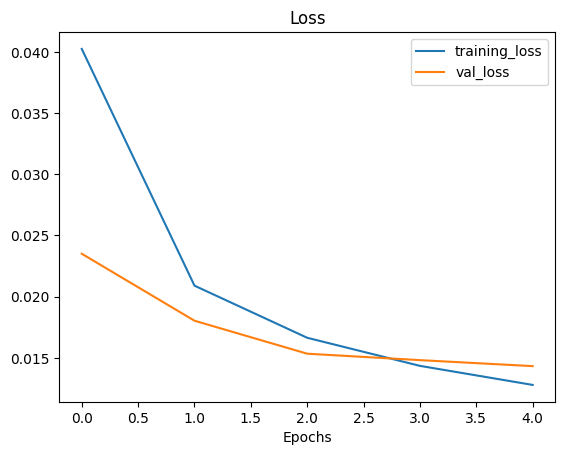

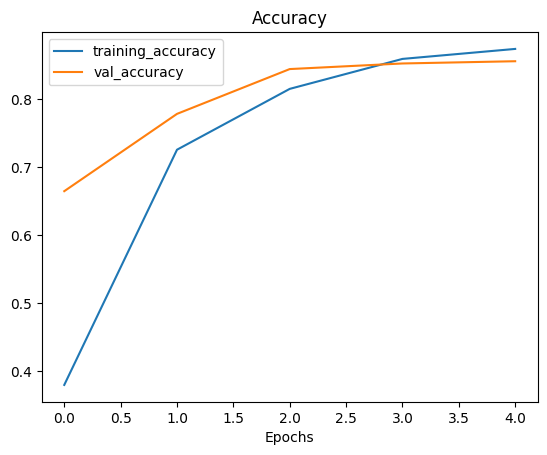

In [12]:
# Check out our model's training curves
plot_loss_curves(model_0_history)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [13]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor} \n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [14]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

> **Note:** One of the reasons feture extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer which can then be used to extract patterns out of for our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics

### Getting and preprocessing data for model_1

In [15]:
# Create training and test dirs
train_dir_1_percent = "../data/10_food_classes_1_percent/train/"
test_dir = "../data/10_food_classes_1_percent/test/"

In [16]:
# How many images we work with
walk_through_dir("../data/10_food_classes_1_percent/")

There are 2 directories and 0 images in '../data/10_food_classes_1_percent/'.
There are 10 directories and 0 images in '../data/10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\chicken_curry'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\chicken_wings'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\fried_rice'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\grilled_salmon'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\hamburger'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\ice_cream'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\pizza'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\ramen'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test

In [17]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE) # default = 32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmentation them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but Efficientnet's having rescaling build in
], name="data_augmentation")